# Solution

## Initialization

In [1]:
from unityagents import UnityEnvironment
import numpy as np

In [2]:
env = UnityEnvironment(file_name='./Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
env_info = env.reset(train_mode=True)[brain_name]
assert len(env_info.agents) == 1
action_size = brain.vector_action_space_size
state_size = env_info.vector_observations.shape[1]

## DDPG

In [5]:
import random
import torch
from collections import deque
from datetime import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from ddpg.ddpg_agent import Agent

In [7]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=2)

In [8]:
def run_ddpg(n_episodes=1000, max_t=1000, print_every=100):
    solved = False
    target_score = 30
    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        ## state = env.reset() 
        state = env_info.vector_observations[0]
        agent.reset()
        score = 0
        for t in range(max_t):
            # while True:
            agent.reset()
            action = agent.act(state)
            
            ## next_state, reward, done, _ = env.step(action) ##
            ## agent.step(state, action, reward, next_state, done) ##
            
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            
            agent.step(state, action, reward, next_state, done)
            
            state = next_state
            score += reward
            if done:
                break 
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(agent.actor_local.state_dict(), f'checkpoints/checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), f'checkpoints/checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=target_score and not solved:
            solved = True
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-print_every, np.mean(scores_deque)))
            timestamp = dt.now().strftime("%Y-%m-%d_%H:%M:%S")
            torch.save(agent.actor_local.state_dict(), f'checkpoints/checkpoint_actor_{timestamp}.pth')
            torch.save(agent.critic_local.state_dict(), f'checkpoints/checkpoint_critic_{timestamp}.pth')
            
    return scores

In [9]:
%%time
scores = run_ddpg(n_episodes=200)

Episode 100	Average Score: 5.74
Episode 186	Average Score: 30.00
Environment solved in 86 episodes!	Average Score: 30.00
Episode 200	Average Score: 33.31
CPU times: user 33min 51s, sys: 51.5 s, total: 34min 43s
Wall time: 57min 43s


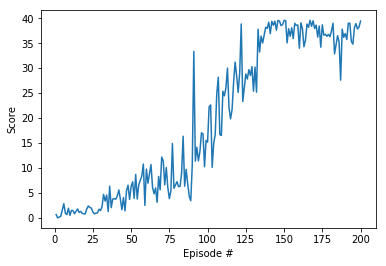

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()